In [1]:
!python -V

Python 3.9.6


In [2]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

import mlflow

/Users/bastienwinant/Desktop/projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc_taxi_experiment")

2024/05/26 11:32:12 INFO mlflow.tracking.fluent: Experiment with name 'nyc_taxi_experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='/Users/bastienwinant/Desktop/projects/mlops-zoomcamp/experiment-tracking/mlruns/1', creation_time=1716715932380, experiment_id='1', last_update_time=1716715932380, lifecycle_stage='active', name='nyc_taxi_experiment', tags={}>

In [4]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [5]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

/Users/bastienwinant/Desktop/projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


9.838799799829628

/var/folders/87/zcq_b8352pg1_6l13vsrjj480000gn/T/ipykernel_1883/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/var/folders/87/zcq_b8352pg1_6l13vsrjj480000gn/T/ipykernel_1883/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label

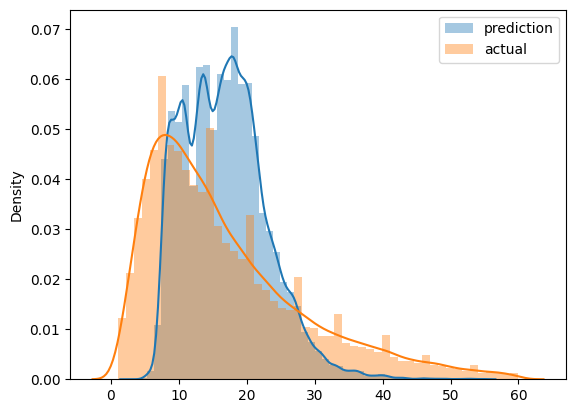

In [6]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [7]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [8]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')

In [9]:
len(df_train), len(df_val)

(73908, 61921)

In [10]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [11]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [12]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [13]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/Users/bastienwinant/Desktop/projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.758715200888857

In [14]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [22]:
with mlflow.start_run():
  mlflow.set_tag('developer', 'armand winant')

  mlflow.log_param('train-data-path', 'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
  mlflow.log_param('valid-data-path', 'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')
  
  alpha = 0.01
  mlflow.log_param('alpha', alpha)

  lr = Lasso(0.01)
  lr.fit(X_train, y_train)

  y_pred = lr.predict(X_val)

  rmse = mean_squared_error(y_val, y_pred, squared=False)
  mlflow.log_metric('rmse', rmse)

  mlflow.log_artifact(local_path='models/lin_reg.bin', artifact_path='models_pickle')


/Users/bastienwinant/Desktop/projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [16]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [17]:
def objective(params):
  with mlflow.start_run():
    mlflow.set_tag('model', 'xgboost')
    mlflow.log_params(params)

    booster = xgb.train(
      params=params,
      dtrain=train,
      num_boost_round=100,
      evals=[(valid, "validation")],
      early_stopping_rounds=10
    )

    y_pred = booster.predict(valid)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric('rmse', rmse)

  return {'loss': rmse, 'status': STATUS_OK}

In [18]:
search_space = {
  'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
  'learning_rate': hp.loguniform('learning_rate', -3, 0),
  'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
  'rel_lambda': hp.loguniform('reg_lambda', -6, -1),
  'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
  'objective': 'reg:linear',
  'seed': 42
}

best_result = fmin(
  fn=objective,
  space=search_space,
  algo=tpe.suggest,
  max_evals=10,
  trials=Trials()
)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

/Users/bastienwinant/Desktop/projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:32:26] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

/Users/bastienwinant/Desktop/projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:32:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "rel_lambda" } are not used.

  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.81832                          
[1]	validation-rmse:9.74727                           
[2]	validation-rmse:8.93586                           
[3]	validation-rmse:8.33215                           
[4]	validation-rmse:7.88457                           
[5]	validation-rmse:7.55510                           
[6]	validation-rmse:7.31961                           
[7]	validation-rmse:7.14417                           
[8]	validation-rmse:7.01769                           
[9]	validation-rmse:6.92238                           
[10]	validation-rmse:6.85060                          
[11]	validation-rmse:6.79852                          
[12]	validation-rmse:6.75927                          
[13]	validation-rmse:6.72832                          
[14]	validation-rmse:6.70649                          
[15]	validation-rmse:6.69033                          
[16]	validation-rmse:6.67550                          
[17]	validation-rmse:6.66472                          
[18]	valid

/Users/bastienwinant/Desktop/projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/bastienwinant/Desktop/projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:32:32] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

/Users/bastienwinant/Desktop/projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:32:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "rel_lambda" } are not used.

  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.77375                                                    
[1]	validation-rmse:6.63416                                                    
[2]	validation-rmse:6.62010                                                    
[3]	validation-rmse:6.60997                                                    
[4]	validation-rmse:6.60166                                                    
[5]	validation-rmse:6.59352                                                    
[6]	validation-rmse:6.58500                                                    
[7]	validation-rmse:6.57833                                                    
[8]	validation-rmse:6.57026                                                    
[9]	validation-rmse:6.55706                                                    
[10]	validation-rmse:6.55033                                                   
[11]	validation-rmse:6.54533                                                   
[12]	validation-rmse:6.53756            

/Users/bastienwinant/Desktop/projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/bastienwinant/Desktop/projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:32:37] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

/Users/bastienwinant/Desktop/projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:32:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "rel_lambda" } are not used.

  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.23269                                                    
[1]	validation-rmse:7.77142                                                    
[2]	validation-rmse:7.09290                                                    
[3]	validation-rmse:6.78096                                                    
[4]	validation-rmse:6.63710                                                    
[5]	validation-rmse:6.56198                                                    
[6]	validation-rmse:6.51804                                                    
[7]	validation-rmse:6.48986                                                    
[8]	validation-rmse:6.47392                                                    
[9]	validation-rmse:6.45893                                                    
[10]	validation-rmse:6.44670                                                   
[11]	validation-rmse:6.44051                                                   
[12]	validation-rmse:6.43437            

/Users/bastienwinant/Desktop/projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/bastienwinant/Desktop/projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:32:53] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

/Users/bastienwinant/Desktop/projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:32:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "rel_lambda" } are not used.

  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.15467                                                   
[1]	validation-rmse:8.81173                                                    
[2]	validation-rmse:7.95920                                                    
[3]	validation-rmse:7.42973                                                    
[4]	validation-rmse:7.10550                                                    
[5]	validation-rmse:6.90836                                                    
[6]	validation-rmse:6.78600                                                    
[7]	validation-rmse:6.70812                                                    
[8]	validation-rmse:6.65632                                                    
[9]	validation-rmse:6.62279                                                    
[10]	validation-rmse:6.59752                                                   
[11]	validation-rmse:6.57921                                                   
[12]	validation-rmse:6.56608            

/Users/bastienwinant/Desktop/projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/bastienwinant/Desktop/projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:33:01] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

/Users/bastienwinant/Desktop/projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:33:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "rel_lambda" } are not used.

  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.17906                                                   
[1]	validation-rmse:8.84626                                                    
[2]	validation-rmse:7.99695                                                    
[3]	validation-rmse:7.46549                                                    
[4]	validation-rmse:7.14075                                                    
[5]	validation-rmse:6.93647                                                    
[6]	validation-rmse:6.80824                                                    
[7]	validation-rmse:6.72808                                                    
[8]	validation-rmse:6.67291                                                    
[9]	validation-rmse:6.63551                                                    
[10]	validation-rmse:6.60738                                                   
[11]	validation-rmse:6.58370                                                   
[12]	validation-rmse:6.56802            

/Users/bastienwinant/Desktop/projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/bastienwinant/Desktop/projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:33:15] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

/Users/bastienwinant/Desktop/projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:33:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "rel_lambda" } are not used.

  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:9.70267                                                    
[3]	validation-rmse:9.13743                                                    
[4]	validation-rmse:8.67556                                                    
[5]	validation-rmse:8.30020                                                    
[6]	validation-rmse:7.99648                                                    
[7]	validation-rmse:7.74969                                                    
[8]	validation-rmse:7.55079                                                    
[9]	validation-rmse:7.39273                                                    
[10]	validation-rmse:7.26443                                                   
[11]	validation-rmse:7.16137                                                   
[12]	validation-rmse:7.07871                                                   
[13]	validation-rmse:7.01063                                                   
[14]	validation-rmse:6.95533            

/Users/bastienwinant/Desktop/projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/bastienwinant/Desktop/projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:33:19] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

/Users/bastienwinant/Desktop/projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:33:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "rel_lambda" } are not used.

  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.82540                                                   
[1]	validation-rmse:9.76050                                                    
[2]	validation-rmse:8.95468                                                    
[3]	validation-rmse:8.35154                                                    
[4]	validation-rmse:7.90567                                                    
[5]	validation-rmse:7.57864                                                    
[6]	validation-rmse:7.33900                                                    
[7]	validation-rmse:7.16327                                                    
[8]	validation-rmse:7.03427                                                    
[9]	validation-rmse:6.93968                                                    
[10]	validation-rmse:6.86940                                                   
[11]	validation-rmse:6.81646                                                   
[12]	validation-rmse:6.77646            

/Users/bastienwinant/Desktop/projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/bastienwinant/Desktop/projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:33:27] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

/Users/bastienwinant/Desktop/projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:33:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "rel_lambda" } are not used.

  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:11.33402                                                   
[2]	validation-rmse:10.94343                                                   
[3]	validation-rmse:10.58316                                                   
[4]	validation-rmse:10.25126                                                   
[5]	validation-rmse:9.94560                                                    
[6]	validation-rmse:9.66463                                                    
[7]	validation-rmse:9.40646                                                    
[8]	validation-rmse:9.16957                                                    
[9]	validation-rmse:8.95257                                                    
[10]	validation-rmse:8.75404                                                   
[11]	validation-rmse:8.57269                                                   
[12]	validation-rmse:8.40724                                                   
[13]	validation-rmse:8.25612            

/Users/bastienwinant/Desktop/projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/bastienwinant/Desktop/projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:33:42] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

/Users/bastienwinant/Desktop/projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:33:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "rel_lambda" } are not used.

  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:10.92468                                                   
[2]	validation-rmse:10.38896                                                   
[3]	validation-rmse:9.91647                                                    
[4]	validation-rmse:9.50107                                                    
[5]	validation-rmse:9.13655                                                    
[6]	validation-rmse:8.81787                                                    
[7]	validation-rmse:8.54012                                                    
[8]	validation-rmse:8.29832                                                    
[9]	validation-rmse:8.08832                                                    
[10]	validation-rmse:7.90641                                                   
[11]	validation-rmse:7.74834                                                   
[12]	validation-rmse:7.61167                                                   
[13]	validation-rmse:7.49371            

/Users/bastienwinant/Desktop/projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/bastienwinant/Desktop/projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:33:48] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

/Users/bastienwinant/Desktop/projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:33:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "rel_lambda" } are not used.

  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.73512                                                   
[1]	validation-rmse:11.29456                                                   
[2]	validation-rmse:10.88832                                                   
[3]	validation-rmse:10.51497                                                   
[4]	validation-rmse:10.17202                                                   
[5]	validation-rmse:9.85739                                                    
[6]	validation-rmse:9.56931                                                    
[7]	validation-rmse:9.30506                                                    
[8]	validation-rmse:9.06383                                                    
[9]	validation-rmse:8.84462                                                    
[10]	validation-rmse:8.64450                                                   
[11]	validation-rmse:8.46241                                                   
[12]	validation-rmse:8.29677            

/Users/bastienwinant/Desktop/projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



In [20]:
params = {
  'learning_rate': 0.392765789577779,
  'max_depth':  87,
  'min_child_weight': 3.6970857159763146,
  'objective': 'reg:linear',
  'reg_alpha': 0.1292359903223133,
  'rel_lambda': 0.06307285655874986,
  'seed': 42
}

mlflow.xgboost.autolog()

booster = xgb.train(
  params=params,
  dtrain=train,
  num_boost_round=100,
  evals=[(valid, "validation")],
  early_stopping_rounds=10
)

2024/05/26 11:46:25 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '5fd49b04ec19432896a95c50b139e5ef', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
/Users/bastienwinant/Desktop/projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:46:36] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/bastienwinant/Desktop/projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:46:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "rel_lambda" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:9.23269
[1]	validation-rmse:7.77142
[2]	validation-rmse:7.09290
[3]	validation-rmse:6.78096
[4]	validation-rmse:6.63710
[5]	validation-rmse:6.56198
[6]	validation-rmse:6.51804
[7]	validation-rmse:6.48986
[8]	validation-rmse:6.47392
[9]	validation-rmse:6.45893
[10]	validation-rmse:6.44670
[11]	validation-rmse:6.44051
[12]	validation-rmse:6.43437
[13]	validation-rmse:6.43036
[14]	validation-rmse:6.42613
[15]	validation-rmse:6.42294
[16]	validation-rmse:6.41841
[17]	validation-rmse:6.41585
[18]	validation-rmse:6.41350
[19]	validation-rmse:6.41044
[20]	validation-rmse:6.40844
[21]	validation-rmse:6.40691
[22]	validation-rmse:6.40531
[23]	validation-rmse:6.40356
[24]	validation-rmse:6.39911
[25]	validation-rmse:6.39798
[26]	validation-rmse:6.39680
[27]	validation-rmse:6.39561
[28]	validation-rmse:6.39420
[29]	validation-rmse:6.39343
[30]	validation-rmse:6.39260
[31]	validation-rmse:6.39210
[32]	validation-rmse:6.39028
[33]	validation-rmse:6.38900
[34]	validation-rmse:6.3

2024/05/26 11:47:13 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2024/05/26 11:47:13 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/bastienwinant/Desktop/projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:47:13] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."


In [ ]:
mlflow.xgboost.autolog(disable=True)

In [24]:
with mlflow.start_run():
  params = {
    'learning_rate': 0.392765789577779,
    'max_depth':  87,
    'min_child_weight': 3.6970857159763146,
    'objective': 'reg:linear',
    'reg_alpha': 0.1292359903223133,
    'rel_lambda': 0.06307285655874986,
    'seed': 42
  }

  mlflow.log_params(params)

  booster = xgb.train(
    params=params,
    dtrain=train,
    num_boost_round=100,
    evals=[(valid, "validation")],
    early_stopping_rounds=10
  )

  y_pred = booster.predict(valid)
  rmse = mean_squared_error(y_val, y_pred, squared=False)
  mlflow.log_metric('rmse', rmse)

  with open('models/preprocessor.p', 'wb') as f_out:
    pickle.dump(dv, f_out)
    
  mlflow.log_artifact(local_path='models/preprocessor.p', artifact_path='preprocessor')
  mlflow.xgboost.log_model(booster, artifact_path='xgboost-model')

/Users/bastienwinant/Desktop/projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:07:20] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/bastienwinant/Desktop/projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:07:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "rel_lambda" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:9.23269
[1]	validation-rmse:7.77142
[2]	validation-rmse:7.09290
[3]	validation-rmse:6.78096
[4]	validation-rmse:6.63710
[5]	validation-rmse:6.56198
[6]	validation-rmse:6.51804
[7]	validation-rmse:6.48986
[8]	validation-rmse:6.47392
[9]	validation-rmse:6.45893
[10]	validation-rmse:6.44670
[11]	validation-rmse:6.44051
[12]	validation-rmse:6.43437
[13]	validation-rmse:6.43036
[14]	validation-rmse:6.42613
[15]	validation-rmse:6.42294
[16]	validation-rmse:6.41841
[17]	validation-rmse:6.41585
[18]	validation-rmse:6.41350
[19]	validation-rmse:6.41044
[20]	validation-rmse:6.40844
[21]	validation-rmse:6.40691
[22]	validation-rmse:6.40531
[23]	validation-rmse:6.40356
[24]	validation-rmse:6.39911
[25]	validation-rmse:6.39798
[26]	validation-rmse:6.39680
[27]	validation-rmse:6.39561
[28]	validation-rmse:6.39420
[29]	validation-rmse:6.39343
[30]	validation-rmse:6.39260
[31]	validation-rmse:6.39210
[32]	validation-rmse:6.39028
[33]	validation-rmse:6.38900
[34]	validation-rmse:6.3

2024/05/26 12:07:57 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2024/05/26 12:07:57 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/bastienwinant/Desktop/projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:07:57] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."
/Users/bastienwinant/Desktop/projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/bastienwinant/Desktop/projects/ml

In [31]:
logged_model = 'runs:/fd6ea200de874fe381d3ab1c4f4b0095/xgboost-model'
python_model = mlflow.pyfunc.load_model(logged_model)

/Users/bastienwinant/Desktop/projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:12:18] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [32]:
xgboost_model = mlflow.xgboost.load_model(logged_model)

/Users/bastienwinant/Desktop/projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:12:20] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [33]:
xgboost_model

In [34]:
python_model

mlflow.pyfunc.loaded_model:
  artifact_path: xgboost-model
  flavor: mlflow.xgboost
  run_id: fd6ea200de874fe381d3ab1c4f4b0095

In [35]:
y_pred = xgboost_model.predict(valid)

In [36]:
y_pred

array([13.902527 ,  6.468545 , 12.704544 , ..., 13.694024 ,  6.1406865,
        7.721512 ], dtype=float32)